# Trousers and jeans model

0 - Male trousers
1 - Female trousers
2 - Male jeans
3 - Female jeans

Conv2D -> MaxPooling2D - > Conv2D -> MaxPooling2D - > Flatten - > Dense ->  Dense 

# Import relevant libraries

In [1]:
import io
import itertools
import numpy as np
import sklearn.metrics
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt

# Load the data

Data train files: ['images', 'labels', 'genders']
Size of the images: (4004, 120, 90, 3)
Size of the labels: (4004,)
Unique values of the labels: [0 1 2 3]
The label of 2796'th image is 1
The label of 1957'th image is 0


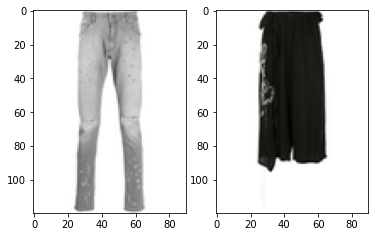

In [2]:
data_train = np.load(r"data/Trousers & Jeans - All - Train.npz")
data_validation = np.load(r"data/Trousers & Jeans - All - Validation.npz")
data_test = np.load(r"data/Trousers & Jeans - All - Test.npz")

print("Data train files: {}".format(data_train.files))
print("Size of the images: {}".format(data_train['images'].shape))
print("Size of the labels: {}".format(data_train['labels'].shape))
print("Unique values of the labels: {}".format(np.unique(data_train['labels'])))
n = np.random.randint(0, 4002)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data_train['images'][n])
print("The label of {}'th image is {}".format(n, data_train['labels'][n]))

n = np.random.randint(0, 4002)
ax2.imshow(data_train['images'][n])
print("The label of {}'th image is {}".format(n, data_train['labels'][n]))

In [3]:
images_train = data_train['images']
labels_train = data_train['labels']

images_val = data_validation['images']
labels_val = data_validation['labels']

images_test = data_test['images']
labels_test = data_test['labels']

In [4]:
images_train = images_train/255.0
images_val = images_val/255.0
images_test = images_test/255.0 

# Training the models

In [5]:
EPOCHS = 15
BATCH_SIZE = 64 #power of 2

HP_FILTER_SIZE_1 = hp.HParam('filter_size_1', hp.Discrete([3,5,7]))
HP_FILTER_NUM = hp.HParam('filters_number', hp.Discrete([32,64,96,128]))
HP_FILTER_SIZE_2 = hp.HParam('filter_size_2', hp.Discrete([3,5]))
HP_DENSE_SIZE = hp.HParam('dense_size', hp.Discrete([256,512,1024]))

METRIC_ACCURACY = "accuracy"

with tf.summary.create_file_writer(r'Logs/Model 3_3/hparam_tuning/').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE_1, HP_FILTER_NUM, HP_FILTER_SIZE_2, HP_DENSE_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [6]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [7]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [8]:
def train_test_model(hparams, session_num):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            hparams[HP_FILTER_NUM], 
            hparams[HP_FILTER_SIZE_1], 
            activation='relu',
            input_shape=(120,90,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(
            hparams[HP_FILTER_NUM], 
            hparams[HP_FILTER_SIZE_2], 
            activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hparams[HP_DENSE_SIZE], activation='relu'),
        tf.keras.layers.Dense(4)
    ])
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer="adam", loss=loss_fn, metrics=['accuracy'])
    

    log_dir = "Logs\\Model 3_3\\fit\\" + "run {}".format(session_num)
    
  
    file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
    
    def log_confusion_matrix(epoch, logs):
        
        test_pred_raw = model.predict(images_val)
        test_pred = np.argmax(test_pred_raw, axis=1)

        
        cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
       
        figure = plot_confusion_matrix(cm, class_names=['Trousers Male', 'Jeans Male', 'Trousers Female', 'Jeans Female'])
        cm_image = plot_to_image(figure)

        
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
    
    
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
    cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
    

    
 
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0, 
        restore_best_weights = True
    )
    

    model.fit(
        images_train,
        labels_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks = [tensorboard_callback, cm_callback, early_stopping],
        validation_data = (images_val,labels_val),
        verbose = 2
    )
    
    

    _, accuracy = model.evaluate(images_val,labels_val)
    

    model.save(r"saved_models\Model 3_3\Run-{}".format(session_num))
    
    return accuracy

In [9]:
def run(log_dir, hparams, session_num):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model(hparams, session_num)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step = 1)

In [10]:
session_num = 1

for filter_size_1 in HP_FILTER_SIZE_1.domain.values:
    for filter_num in HP_FILTER_NUM.domain.values:
        for filter_size_2 in HP_FILTER_SIZE_2.domain.values:
            for dense_size in HP_DENSE_SIZE.domain.values:

                    hparams = {
                        HP_FILTER_SIZE_1: filter_size_1,
                        HP_FILTER_NUM: filter_num,
                        HP_FILTER_SIZE_2: filter_size_2,
                        HP_DENSE_SIZE: dense_size
                    }

                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run('Logs/Model 3_3/hparam_tuning/' + run_name, hparams, session_num)

                    session_num += 1

--- Starting trial: run-1
{'filter_size_1': 3, 'filters_number': 32, 'filter_size_2': 3, 'dense_size': 256}
Epoch 1/15
63/63 - 21s - loss: 1.2002 - accuracy: 0.5045 - val_loss: 1.1442 - val_accuracy: 0.5540
Epoch 2/15
63/63 - 19s - loss: 0.8452 - accuracy: 0.6648 - val_loss: 0.8741 - val_accuracy: 0.6580
Epoch 3/15
63/63 - 19s - loss: 0.7532 - accuracy: 0.6913 - val_loss: 0.8603 - val_accuracy: 0.6520
Epoch 4/15
63/63 - 20s - loss: 0.6509 - accuracy: 0.7445 - val_loss: 0.7927 - val_accuracy: 0.6600
Epoch 5/15
63/63 - 17s - loss: 0.5859 - accuracy: 0.7712 - val_loss: 0.7459 - val_accuracy: 0.7020
Epoch 6/15
63/63 - 20s - loss: 0.5760 - accuracy: 0.7692 - val_loss: 0.7078 - val_accuracy: 0.7260
Epoch 7/15
63/63 - 20s - loss: 0.4950 - accuracy: 0.8087 - val_loss: 0.7224 - val_accuracy: 0.7180
Epoch 8/15
63/63 - 19s - loss: 0.4452 - accuracy: 0.8309 - val_loss: 0.7700 - val_accuracy: 0.7160
16/16 [==============================] - 1s 33ms/step - loss: 0.7078 - accuracy: 0.7260
INFO:tensorf

Epoch 6/15
63/63 - 43s - loss: 0.5643 - accuracy: 0.7797 - val_loss: 0.7710 - val_accuracy: 0.7040
Epoch 7/15
63/63 - 43s - loss: 0.5175 - accuracy: 0.7980 - val_loss: 0.7921 - val_accuracy: 0.7240
16/16 [==============================] - 1s 86ms/step - loss: 0.7648 - accuracy: 0.7140
INFO:tensorflow:Assets written to: saved_models\Model 3_3\Run-8\assets
--- Starting trial: run-9
{'filter_size_1': 3, 'filters_number': 64, 'filter_size_2': 3, 'dense_size': 1024}
Epoch 1/15
63/63 - 54s - loss: 1.3385 - accuracy: 0.5142 - val_loss: 1.0055 - val_accuracy: 0.5820
Epoch 2/15
63/63 - 51s - loss: 0.8119 - accuracy: 0.6666 - val_loss: 0.8932 - val_accuracy: 0.6480
Epoch 3/15
63/63 - 53s - loss: 0.7189 - accuracy: 0.7063 - val_loss: 0.7810 - val_accuracy: 0.6960
Epoch 4/15
63/63 - 45s - loss: 0.6451 - accuracy: 0.7425 - val_loss: 0.7831 - val_accuracy: 0.6760
Epoch 5/15
63/63 - 54s - loss: 0.5550 - accuracy: 0.7815 - val_loss: 0.7077 - val_accuracy: 0.7260
Epoch 6/15
63/63 - 52s - loss: 0.4809 -

Epoch 6/15
63/63 - 95s - loss: 0.5568 - accuracy: 0.7800 - val_loss: 0.7533 - val_accuracy: 0.7260
Epoch 7/15
63/63 - 95s - loss: 0.5364 - accuracy: 0.7932 - val_loss: 0.7637 - val_accuracy: 0.7020
16/16 [==============================] - 3s 154ms/step - loss: 0.7475 - accuracy: 0.7100
INFO:tensorflow:Assets written to: saved_models\Model 3_3\Run-16\assets
--- Starting trial: run-17
{'filter_size_1': 3, 'filters_number': 96, 'filter_size_2': 5, 'dense_size': 512}
Epoch 1/15
63/63 - 95s - loss: 1.4531 - accuracy: 0.4496 - val_loss: 1.0442 - val_accuracy: 0.5580
Epoch 2/15
63/63 - 102s - loss: 0.9233 - accuracy: 0.6236 - val_loss: 0.9594 - val_accuracy: 0.6100
Epoch 3/15
63/63 - 107s - loss: 0.8241 - accuracy: 0.6673 - val_loss: 0.9897 - val_accuracy: 0.6280
Epoch 4/15
63/63 - 103s - loss: 0.7450 - accuracy: 0.7040 - val_loss: 0.8520 - val_accuracy: 0.6580
Epoch 5/15
63/63 - 103s - loss: 0.6577 - accuracy: 0.7483 - val_loss: 0.8575 - val_accuracy: 0.6640
Epoch 6/15
63/63 - 104s - loss: 0

63/63 - 131s - loss: 1.6441 - accuracy: 0.4818 - val_loss: 1.0412 - val_accuracy: 0.6060
Epoch 2/15
63/63 - 131s - loss: 0.8830 - accuracy: 0.6424 - val_loss: 0.9360 - val_accuracy: 0.6420
Epoch 3/15
63/63 - 122s - loss: 0.7520 - accuracy: 0.6961 - val_loss: 0.9476 - val_accuracy: 0.5860
Epoch 4/15
63/63 - 122s - loss: 0.7118 - accuracy: 0.7158 - val_loss: 0.8207 - val_accuracy: 0.6760
Epoch 5/15
63/63 - 124s - loss: 0.6557 - accuracy: 0.7415 - val_loss: 0.7703 - val_accuracy: 0.6980
Epoch 6/15
63/63 - 123s - loss: 0.6223 - accuracy: 0.7585 - val_loss: 0.8404 - val_accuracy: 0.6740
Epoch 7/15
63/63 - 122s - loss: 0.5620 - accuracy: 0.7787 - val_loss: 0.7339 - val_accuracy: 0.7380
Epoch 8/15
63/63 - 124s - loss: 0.5179 - accuracy: 0.8007 - val_loss: 0.7953 - val_accuracy: 0.7260
Epoch 9/15
63/63 - 124s - loss: 0.4636 - accuracy: 0.8199 - val_loss: 0.7408 - val_accuracy: 0.7260
16/16 [==============================] - 3s 213ms/step - loss: 0.7339 - accuracy: 0.7380
INFO:tensorflow:Assets

Epoch 5/15
63/63 - 18s - loss: 0.6329 - accuracy: 0.7405 - val_loss: 0.8860 - val_accuracy: 0.6600
Epoch 6/15
63/63 - 18s - loss: 0.6685 - accuracy: 0.7305 - val_loss: 0.8297 - val_accuracy: 0.6860
Epoch 7/15
63/63 - 18s - loss: 0.5916 - accuracy: 0.7635 - val_loss: 0.8523 - val_accuracy: 0.6880
Epoch 8/15
63/63 - 18s - loss: 0.5209 - accuracy: 0.7867 - val_loss: 0.8014 - val_accuracy: 0.6920
Epoch 9/15
63/63 - 19s - loss: 0.4667 - accuracy: 0.8097 - val_loss: 0.8297 - val_accuracy: 0.7040
Epoch 10/15
63/63 - 19s - loss: 0.4175 - accuracy: 0.8349 - val_loss: 0.8025 - val_accuracy: 0.7340
16/16 [==============================] - 0s 29ms/step - loss: 0.8014 - accuracy: 0.6920
INFO:tensorflow:Assets written to: saved_models\Model 3_3\Run-30\assets
--- Starting trial: run-31
{'filter_size_1': 5, 'filters_number': 64, 'filter_size_2': 3, 'dense_size': 256}
Epoch 1/15
63/63 - 23s - loss: 1.1944 - accuracy: 0.5117 - val_loss: 1.2185 - val_accuracy: 0.4680
Epoch 2/15
63/63 - 22s - loss: 0.8932

Epoch 9/15
63/63 - 38s - loss: 0.5310 - accuracy: 0.7860 - val_loss: 0.7844 - val_accuracy: 0.6560
Epoch 10/15
63/63 - 38s - loss: 0.4874 - accuracy: 0.8039 - val_loss: 0.7499 - val_accuracy: 0.7140
Epoch 11/15
63/63 - 39s - loss: 0.4586 - accuracy: 0.8264 - val_loss: 0.8374 - val_accuracy: 0.6740
Epoch 12/15
63/63 - 38s - loss: 0.4481 - accuracy: 0.8182 - val_loss: 0.7954 - val_accuracy: 0.7140
16/16 [==============================] - 1s 59ms/step - loss: 0.7499 - accuracy: 0.7140
INFO:tensorflow:Assets written to: saved_models\Model 3_3\Run-37\assets
--- Starting trial: run-38
{'filter_size_1': 5, 'filters_number': 96, 'filter_size_2': 3, 'dense_size': 512}
Epoch 1/15
63/63 - 41s - loss: 1.4679 - accuracy: 0.4738 - val_loss: 1.0519 - val_accuracy: 0.5280
Epoch 2/15
63/63 - 38s - loss: 0.8790 - accuracy: 0.6384 - val_loss: 0.9122 - val_accuracy: 0.6460
Epoch 3/15
63/63 - 38s - loss: 0.7943 - accuracy: 0.6736 - val_loss: 0.8433 - val_accuracy: 0.6620
Epoch 4/15
63/63 - 38s - loss: 0.68

Epoch 7/15
63/63 - 52s - loss: 0.5579 - accuracy: 0.7727 - val_loss: 0.8825 - val_accuracy: 0.6820
16/16 [==============================] - 1s 84ms/step - loss: 0.7625 - accuracy: 0.6880
INFO:tensorflow:Assets written to: saved_models\Model 3_3\Run-43\assets
--- Starting trial: run-44
{'filter_size_1': 5, 'filters_number': 128, 'filter_size_2': 3, 'dense_size': 512}
Epoch 1/15
63/63 - 56s - loss: 1.3898 - accuracy: 0.5115 - val_loss: 1.0564 - val_accuracy: 0.5740
Epoch 2/15
63/63 - 54s - loss: 0.8770 - accuracy: 0.6404 - val_loss: 0.8638 - val_accuracy: 0.6540
Epoch 3/15
63/63 - 54s - loss: 0.7756 - accuracy: 0.6813 - val_loss: 0.9273 - val_accuracy: 0.6500
Epoch 4/15
63/63 - 55s - loss: 0.6783 - accuracy: 0.7243 - val_loss: 0.8565 - val_accuracy: 0.6620
Epoch 5/15
63/63 - 54s - loss: 0.6360 - accuracy: 0.7400 - val_loss: 0.7806 - val_accuracy: 0.6940
Epoch 6/15
63/63 - 55s - loss: 0.5936 - accuracy: 0.7560 - val_loss: 0.7457 - val_accuracy: 0.6880
Epoch 7/15
63/63 - 55s - loss: 0.5398

Epoch 5/15
63/63 - 16s - loss: 0.6945 - accuracy: 0.7135 - val_loss: 0.9684 - val_accuracy: 0.6240
16/16 [==============================] - 0s 26ms/step - loss: 0.8550 - accuracy: 0.6500
INFO:tensorflow:Assets written to: saved_models\Model 3_3\Run-51\assets
--- Starting trial: run-52
{'filter_size_1': 7, 'filters_number': 32, 'filter_size_2': 5, 'dense_size': 256}
Epoch 1/15
63/63 - 18s - loss: 1.1868 - accuracy: 0.4875 - val_loss: 1.0786 - val_accuracy: 0.5600
Epoch 2/15
63/63 - 18s - loss: 0.8947 - accuracy: 0.6364 - val_loss: 1.0005 - val_accuracy: 0.5860
Epoch 3/15
63/63 - 18s - loss: 0.8340 - accuracy: 0.6663 - val_loss: 0.8633 - val_accuracy: 0.6380
Epoch 4/15
63/63 - 18s - loss: 0.7236 - accuracy: 0.7048 - val_loss: 0.8165 - val_accuracy: 0.6640
Epoch 5/15
63/63 - 18s - loss: 0.6686 - accuracy: 0.7215 - val_loss: 0.7826 - val_accuracy: 0.6800
Epoch 6/15
63/63 - 19s - loss: 0.6135 - accuracy: 0.7440 - val_loss: 0.7607 - val_accuracy: 0.7020
Epoch 7/15
63/63 - 18s - loss: 0.5791 

Epoch 11/15
63/63 - 60s - loss: 0.6427 - accuracy: 0.7408 - val_loss: 0.8682 - val_accuracy: 0.6480
Epoch 12/15
63/63 - 61s - loss: 0.6232 - accuracy: 0.7448 - val_loss: 0.7811 - val_accuracy: 0.7040
Epoch 13/15
63/63 - 60s - loss: 0.6234 - accuracy: 0.7490 - val_loss: 0.8453 - val_accuracy: 0.6380
Epoch 14/15
63/63 - 63s - loss: 0.5814 - accuracy: 0.7622 - val_loss: 1.0117 - val_accuracy: 0.6580
16/16 [==============================] - 2s 92ms/step - loss: 0.7811 - accuracy: 0.7040
INFO:tensorflow:Assets written to: saved_models\Model 3_3\Run-65\assets
--- Starting trial: run-66
{'filter_size_1': 7, 'filters_number': 96, 'filter_size_2': 5, 'dense_size': 1024}
Epoch 1/15
63/63 - 69s - loss: 1.7228 - accuracy: 0.4056 - val_loss: 1.1111 - val_accuracy: 0.5340
Epoch 2/15
63/63 - 69s - loss: 0.9688 - accuracy: 0.6031 - val_loss: 1.0453 - val_accuracy: 0.5520
Epoch 3/15
63/63 - 70s - loss: 0.8861 - accuracy: 0.6409 - val_loss: 0.9112 - val_accuracy: 0.6340
Epoch 4/15
63/63 - 68s - loss: 0.

Epoch 6/15
63/63 - 88s - loss: 0.6613 - accuracy: 0.7215 - val_loss: 0.8029 - val_accuracy: 0.7060
Epoch 7/15
63/63 - 87s - loss: 0.6262 - accuracy: 0.7438 - val_loss: 0.7906 - val_accuracy: 0.7180
Epoch 8/15
63/63 - 88s - loss: 0.5770 - accuracy: 0.7725 - val_loss: 0.7862 - val_accuracy: 0.7300
Epoch 9/15
63/63 - 87s - loss: 0.5318 - accuracy: 0.7820 - val_loss: 0.7991 - val_accuracy: 0.7060
Epoch 10/15
63/63 - 87s - loss: 0.4969 - accuracy: 0.7942 - val_loss: 0.7645 - val_accuracy: 0.7040
Epoch 11/15
63/63 - 87s - loss: 0.4583 - accuracy: 0.8179 - val_loss: 0.7118 - val_accuracy: 0.7340
Epoch 12/15
63/63 - 87s - loss: 0.4080 - accuracy: 0.8369 - val_loss: 0.7319 - val_accuracy: 0.7520
Epoch 13/15
63/63 - 87s - loss: 0.4017 - accuracy: 0.8379 - val_loss: 0.7189 - val_accuracy: 0.7300
16/16 [==============================] - 2s 147ms/step - loss: 0.7118 - accuracy: 0.7340
INFO:tensorflow:Assets written to: saved_models\Model 3_3\Run-72\assets


In [2]:
%load_ext tensorboard
%tensorboard --logdir "Logs/Model 3_3/hparam_tuning"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
